In [2]:
import matplotlib.pyplot as plt
import numpy as np

c_ampArray = np.linspace(0, 0.8, 81)
g_ampArray = np.linspace(0, 0.8, 81)

from src.utils.data_utils import h5py_load
glist = h5py_load("snail_death", "snail_death")["snail_death"]

def check_snail(gc, gg):
    """returns true if snail still alive"""
    c_ampArray = np.linspace(0, 0.8, 81)
    g_ampArray = np.linspace(0, 0.8, 81)

    x = np.where(c_ampArray == gc)[0]
    y = np.where(g_ampArray == gg)[0]
    return glist.T[x,y] > 0.5

def get_speedlimit(gc, gg):
    """Find highest amps (preserving gate ratio) where snail still alive
    TODO Make this way smarter by using parametric functions and finding intercepts!
    Failing now because not all values are contained in glist linspace array"""
    upper_bound_scale = np.min([0.8/gc, 0.8/gg])
    scale = upper_bound_scale
    y= lambda x: gg/gc
    while (gc > 1e-6 and gg > 1e-6) and scale > 0:
        sc, sg = gc*scale, gg*scale
        scale -= .01 #shrink ratio until valid
        if check_snail(sc, sg):
            break
    return sc, sg

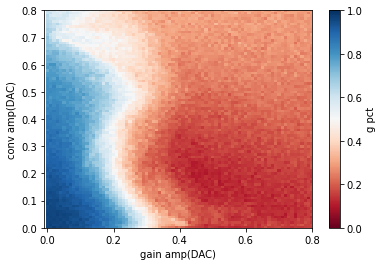

In [3]:
plt.figure()
plt.pcolormesh(g_ampArray, c_ampArray, glist.T, cmap='RdBu', vmax=1, vmin=0)
plt.xlabel("gain amp(DAC)")
plt.ylabel('conv amp(DAC)')
cbar = plt.colorbar()
plt.ylim(0,.8)
plt.xlim(-0.01,.8)
cbar.set_label("g pct", rotation=90)

In [4]:
# step 1 data cleaning
glist_temp = glist.copy()
for j in range(glist.shape[0]):
    for i in range(glist.shape[1]):
        if np.abs(glist[i,j] - 0.5) < 0.025:
            glist_temp[i,j] = 1
            #set rest of row to 0
            for k in range(i+1, glist.shape[1]):
                glist_temp[k, j] = 0
            break
        else:
            glist_temp[i,j] = 0

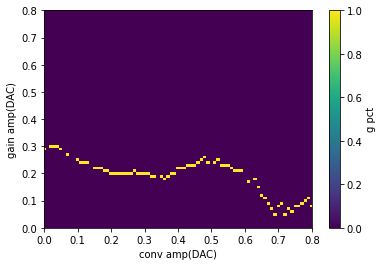

In [5]:
plt.figure()
plt.pcolormesh(c_ampArray, g_ampArray, glist_temp, vmax=1, vmin=0)
plt.ylabel("gain amp(DAC)")
plt.xlabel('conv amp(DAC)')
cbar = plt.colorbar()
plt.xlim(0,.8)
plt.ylim(0,.8)
cbar.set_label("g pct", rotation=90)

In [6]:
#step 2 reduce dimensionality
coords = []
for i in range(glist_temp.shape[0]):
    for j in range(glist_temp.shape[1]):
        if glist_temp[i,j] == 1:
            coords.append([c_ampArray[j], g_ampArray[i]])

coords.sort(key=lambda x: x[0])

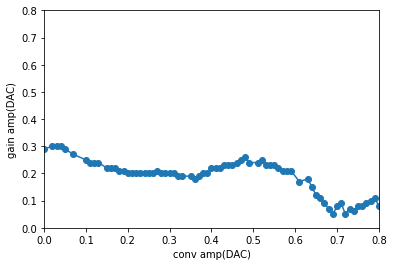

In [7]:
plt.figure()
plt.plot([x[0] for x in coords], [x[1] for x in coords], '-o')
plt.ylabel("gain amp(DAC)")
plt.xlabel('conv amp(DAC)')
plt.xlim(0,.8)
plt.ylim(0,.8)
cbar.set_label("g pct", rotation=90)

In [8]:
# add in point (1,0) to make sure bounded
coords.append([.81,0])

In [9]:
#step 2.5 arbitrary scaling to convert DAC to Hamiltonian (rad/s) ?
#decide to scale so x and y intercept are near pi/2
#scale x axis
x = [x[0]*0.64*np.pi for x in coords]
# scale y axis
y = [x[1]*1.7*np.pi for x in coords]

[1.1382867] [1.1382867]


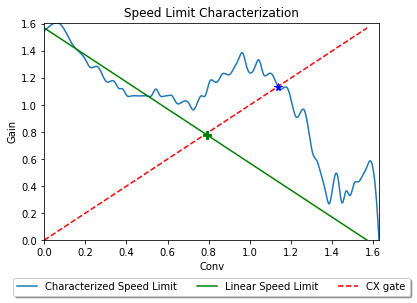

In [55]:
# step 3 univariate spline
from scipy.interpolate import UnivariateSpline
N=800
s = UnivariateSpline(x, y, s=0.001)
xs = np.linspace(0, max(x), N)
plt.figure()
# plt.plot(x, y, 'o', xs, s(xs), '-', label="Characterized Speed Limit")
plt.plot(xs, s(xs), '-', label="Characterized Speed Limit")
plt.ylabel("Gain")
plt.xlabel('Conv')
plt.xlim(0,max(xs))
plt.ylim(0,max(s(xs)))

#also put linear fit on plot
s2 = lambda x: -x + np.pi/2
xs = np.linspace(0, np.pi/2, N)
plt.plot(xs, s2(xs), 'g-', label='Linear Speed Limit')

#plot cnot gate
gate_c = 0.25*np.pi
gate_g = 0.25*np.pi
if gate_c == 0:
    plt.plot([0, 0], [0, max(s(xs))], 'r--', label='CX gate')
else:
    ratio = gate_g/gate_c * xs
    plt.plot(xs, ratio, 'r--', label='CX gate')

#plot intersections
if gate_c == 0:
    idx = 0
    print(xs[idx], s(xs[idx]))
else:
    idx = max(np.argwhere(np.abs(ratio - s(xs)) < 0.01))
    print(xs[idx], ratio[idx])
plt.plot(xs[idx], s(xs[idx]), 'b*', markersize=8)

idx = max(np.argwhere(np.abs(ratio - s2(xs)) < 0.01))
plt.plot(xs[idx], s2(xs[idx]), 'gP', markersize=8)

plt.title("Speed Limit Characterization")
#show legend underneath plot
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=5)
plt.show()

In [10]:
#rewrite ConversionGainGate to have a cost function that is dynamic in the parameters
from src.utils.custom_gates import ConversionGainGate
class SpeedLimitedGate(ConversionGainGate):
    def __init__(self, p1, p2, g1, g2, t_el, speed_limit_function):
        super().__init__(p1, p2, g1, g2, t_el)
        self.g1 = g1 #conversion
        self.g2 = g2 #gain
        self.t_el = t_el
        self.slf = speed_limit_function
        
    def cost(self):
        assert not (self.g1 == 0 and self.g2 ==0)
        norm = np.pi/2
        # get upper bound of g terms from speed limit data
        xs = np.linspace(0, np.pi/2, N)

        if self.g1 == 0:
            idx = 0
            scaled_g1, scaled_g2 = float(xs[idx]), float(s(xs[idx]))
        else:
            ratio = self.g2/self.g1 * xs
            idx = max(np.argwhere(np.abs(ratio - self.slf(xs)) < 0.02))[0]
            scaled_g1, scaled_g2 = float(xs[idx]), float(ratio[idx]) #conversion, gain
        
        #inversely scale time for new g terms
        # should be the same unless either g1 or g2 is 0
        if self.g1 == 0:
            scale = scaled_g2/self.g2
        else:
            scale = scaled_g1/self.g1

        # if scale < 1 means we are decreasing strength, so increase time
        scaled_t = self.t_el / scale

        #cost is duration of gate
        return scaled_t

In [11]:
c = ConversionGainGate(0, 0, .25*np.pi, .25*np.pi, 1)
c.cost()

1.0

In [12]:
c = SpeedLimitedGate(0, 0, .25*np.pi, .25*np.pi, 1, speed_limit_function=s)
c.cost()

0.6876075731497419

In [13]:
s2 = lambda x: -x + np.pi/2
d = SpeedLimitedGate(0, 0, .25*np.pi, .25*np.pi, 1, speed_limit_function=s2)
d.cost()
#rounding error when finding intersection?

0.9888613861386139

In [14]:
e = SpeedLimitedGate(*[0, 0, 0.009817477042468103, 0.18653206380689397, 1], speed_limit_function=s)
e.cost()

0.11613372093023255

[0.78736658] [0.78736658]


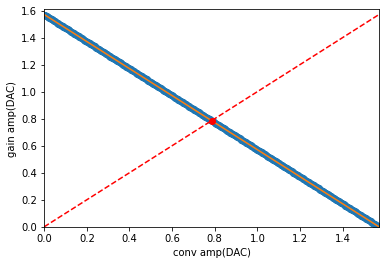

In [21]:
# step 3 univariate spline
from scipy.interpolate import UnivariateSpline
N=400
plt.figure()
s2 = lambda x: -x + np.pi/2
xs = np.linspace(0, np.pi/2, N)

plt.plot(xs, s2(xs), 'o-', xs, s2(xs))
plt.ylabel("gain amp(DAC)")
plt.xlabel('conv amp(DAC)')
plt.xlim(0,max(xs))
plt.ylim(0,max(s(xs)))

#plot cnot gate
gate_c = 0.25*np.pi
gate_g = 0.25*np.pi
if gate_c == 0:
    plt.plot([0, 0], [0, max(s(xs))], 'ro')
else:
    ratio = gate_g/gate_c * xs
    plt.plot(xs, ratio, 'r--')

if gate_c == 0:
    idx = 0
    print(xs[idx], s2(xs[idx]))
else:
    idx = max(np.argwhere(np.abs(ratio - s2(xs)) < 0.01))
    print(xs[idx], ratio[idx])
plt.plot(xs[idx], s2(xs[idx]), 'ro')
plt.show()

In [16]:
np.pi/2

1.5707963267948966